In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import os

Files already downloaded and verified


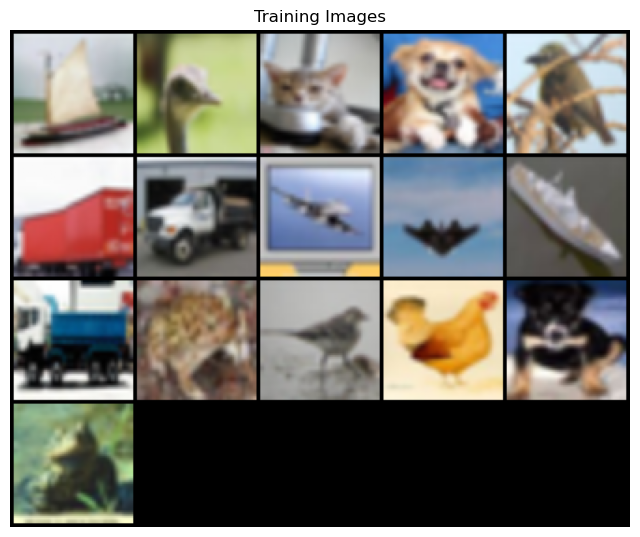

In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

if not os.path.exists('Results'):
   os.makedirs('Results')

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:16],nrow=5, padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig('Results/WGANGP_RealImg.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

In [3]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      #out=128,k=5,s=2,p=1
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  #out=256,k=5,s=2,p=1
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  #out=512,k=5,s=2,p=1
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine =True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)
    
        
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.Gnet(channels_noise, features_g*8, 4, 1, 0),           # 512 x 4 x 4
            self.Gnet(features_g*8, features_g*4, 4, 2, 1),  # 256 x 8 x 8
            self.Gnet(features_g*4, features_g*2, 4, 2, 1),  # 128 x 16 x 16
            self.Gnet(features_g*2, features_g, 4, 2, 1),      # 64 x 32 x 32
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh() #size. (n_channels) x 64 x 64
        
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)
    

    
    
learning_rate = 2e-4
image_size = 64
channels_img = 3  
noise_dim = 100
num_epochs = 20
features_disc = 64 
features_gen = 64 
criticitr = 5
lambda_gp = 10
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            

def GP (critic, real, fake):
    batch_size, C, H, W = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


import os
if not os.path.exists('Models'):
   os.makedirs('Models')


def save_model(model):
    if model == 'gen':
        print("=> Saving model Generator!!")
        torch.save(model, "Models/CIFAR_wganGP_GENERATOR.pth.tar")
    elif model == 'disc':
        print("=> Saving model Discriminator!!")
        torch.save(model, "Models/CIFAR_wganGP_DIS.pth.tar")
        
def load_model(gen,disc):
    print("=> Loading Models!!")
    gen = torch.load("Models/CIFAR_wganGP_GENERATOR.pth.tar")
    disc = torch.load("Models/CIFAR_wganGP_DIS.pth.tar")
    
    
    
gen = Generator(noise_dim, channels_img, features_gen).to(device)
disc = Discriminator(channels_img, features_disc).to(device)
initialize_weights(gen)
initialize_weights(disc)
optimGenerator = optim.RMSprop(gen.parameters(), lr=learning_rate)
optimDiscriminator = optim.RMSprop(disc.parameters(), lr=learning_rate)
fixed_noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
step = 0

gen.train() , disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTr

In [4]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
    """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

/home/arafr/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arafr/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
#training block
GenLoss = []
DiscLoss = []
DiscLossP = []
img_list = []
iters = 0
FID_list = []

print("Training Started")
# start timing
time_start = time.time()
#num_epochs
for epoch in range(num_epochs):
    epoch = epoch+1
    
    for batch_idx, data in enumerate(dataloader,0):
        #training with real batch
        real = data[0].to(device)
        batch = real.shape[0]
        # print(batch == batch_size)

        # Train Critic(Discriminator): max E[critic(real)] - E[critic(fake)]
        for i in range (criticitr):
            noise = torch.randn(batch, noise_dim, 1, 1).to(device)
            fake = gen(noise) #genrator img data
            critic_real = disc(real).reshape(-1)
            critic_fake = disc(fake).reshape(-1)
            gp = GP(disc, real,fake)
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake))+ (lambda_gp*gp))
            disc.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimDiscriminator.step()


        ### Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        output = disc(fake).reshape(-1)
        loss_gen = -torch.mean(output) 
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()


        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_critic.detach().cpu())

        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
    #Cal. FID
    fretchet_dist=calculate_fretchet(real,fake,model)
    FID_list.append(fretchet_dist)
    print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f} ", end="\r", flush=True) 
    
    #Saving Generated image/epoch    
    labels = torch.arange(0,10,dtype = torch.long,device = device)
    noise = torch.randn(10,100,device = device)  
    images = gen(fixed_noise)
    if not os.path.exists('Results/WGANGP_FAKE'):
       os.makedirs('Results/WGANGP_FAKE')
    if not os.path.exists('Results/WGANGP_REAL'):
       os.makedirs('Results/WGANGP_REAL')
    utils.save_image(images.detach(),'Results/WGANGP_FAKE/WGANGP_epoch_%03d.png' % (epoch), normalize = True)
    
    #Saving Real image/epoch 
    real = data[0].to(device)
    utils.save_image(real.detach(),'Results/WGANGP_REAL/WGANGP_epoch_%03d.png' % (epoch), normalize = True)
        
        
time_end = time.time()
print('\n\n elapsed time：%.2f s.'%(time_end-time_start))
# save_model(gen),save_model(disc)

Training Started
Epoch [20/20] Batch 1562/1563                   Loss Discriminator: -10.132, loss Generator: -21.447, FID Score: 293.709 

 elapsed time：5246.21 s.


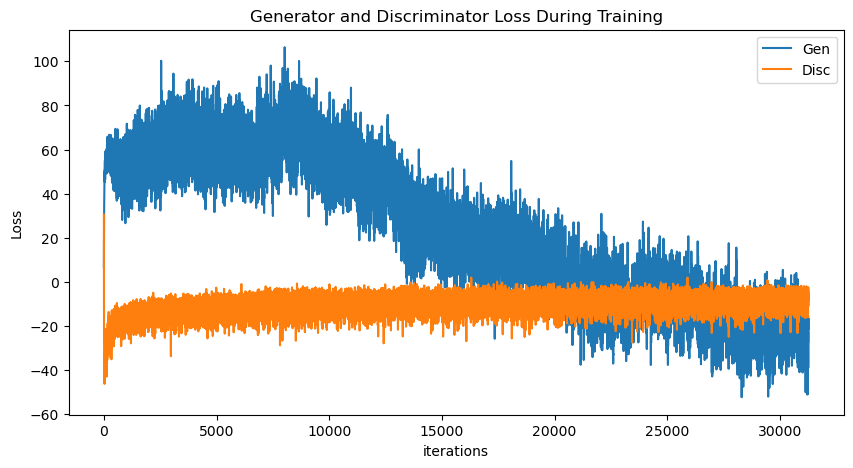

In [7]:
if not os.path.exists('Results/Loss_Data'):
       os.makedirs('Results/Loss_Data')

np.save('Results/Loss_Data/WGANGP_GLoss', GenLoss) 
np.save('Results/Loss_Data/WGANGP_DLoss', DiscLoss) 
GenLoss = np.load('Results/Loss_Data/WGANGP_GLoss.npy')
DiscLoss = np.load('Results/Loss_Data/WGANGP_DLoss.npy')

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Results/Loss.pdf',
            format='pdf',
            dpi=100,
            bbox_inches='tight')
plt.show()

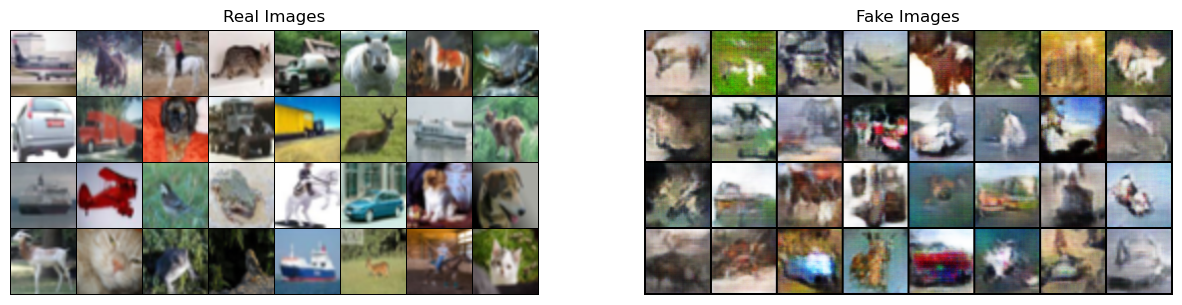

In [8]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('Results/WGANGP_BEST_FAKE_32.pdf',
            format='pdf',
            dpi=100,
            bbox_inches='tight')
plt.show()

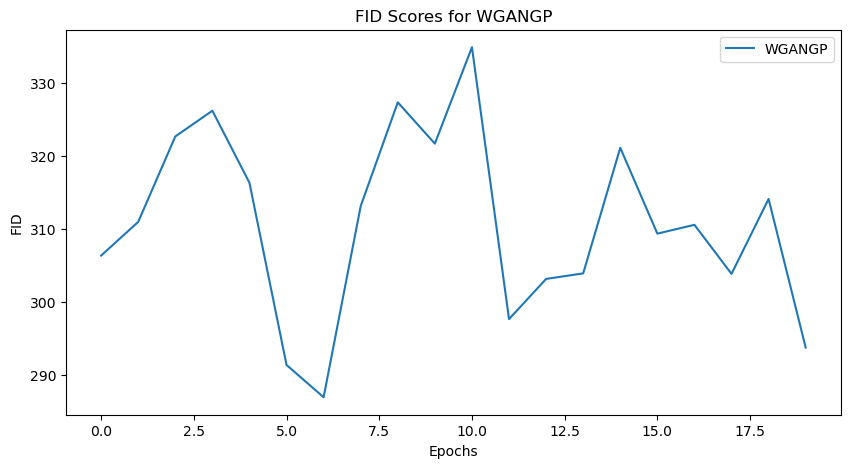

In [9]:
plt.figure(figsize=(10,5))
plt.title("FID Scores for WGANGP")
plt.plot(FID_list,label="WGANGP")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('Results/FID2.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()

In [11]:
if not os.path.exists('Results/FID_score'):
       os.makedirs('Results/FID_score')
np.save('Results/FID_score/WGANGP_FID', FID_list) 